#choosing best architecture

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/*.py
!cat '/content/drive/MyDrive/evaluate_metrics.py'
import sys
sys.path.append('/content/drive/MyDrive')

/content/drive/MyDrive/evaluate_metrics.py
# -*- coding: utf-8 -*-
"""evaluate_metrics.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1Xe35GIPyRDQ19Ai6zDWUCVTG69cd5hea

#Evaluate Metrics: Peak Signal to Nise Ratio
"""

#import needed package
#Calculating peak signal to noise ratio
import numpy as np
from sklearn.metrics import mean_squared_error as MSE
from skimage.metrics import structural_similarity

def PSNR(y_pred, y_true):
  mse=MSE(y_true, y_pred)
  maxi=np.max(y_pred)
  psnr=10*np.log10((maxi**2)/mse)
  return psnr

#Calculating structural similarity index
def SSIM(y_pred, y_true):
  #y_pred_i=y_pred.reshape(y_pred.shape[0],y_pred.shape[1],1)
  #y_true_i=y_true.reshape(y_true.shape[0],y_true.shape[1],1)
  mssim, ssim = structural_similarity(y_true, y_pred, data_range=(y_true.max()-y_true.min()), full=True)
  return mssim, ssim

In [ ]:
#importing packages needed
import numpy as np
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
#from evaluate_metrics import PSNR, SSIM
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, ReLU, BatchNormalization, Dropout, Conv2D, MaxPool2D, Flatten, Reshape, Activation, GaussianNoise, AvgPool2D, Conv1D, GlobalAveragePooling2D, concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
%matplotlib inline 

In [ ]:
def scheduler(epoch, lr):
   if epoch < 10:
     return lr
   else:
     return lr*math.exp(-0.1)
   #if epoch <30:
      #return 0.0005


In [ ]:
LS=tf.keras.callbacks.LearningRateScheduler(scheduler)

#Importing data

In [ ]:
#importing data
hf_data=h5py.File('/content/drive/MyDrive/data.h5', 'r')
data = hf_data['data'][...]
hf_data.close()
hf_mua=h5py.File('/content/drive/MyDrive/mua.h5', 'r')
mua = hf_mua['mua'][...]
hf_mua.close()

In [ ]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)


In [ ]:
#splitting dataset into train,val and test for NOT proccessed dataset
seed=7
np.random.seed(seed)
data_train, data_test, mua_train, mua_test = train_test_split(data, mua, test_size=0.1, random_state=seed)
data_train, data_val, mua_train, mua_val = train_test_split(data_train, mua_train, test_size=0.05, random_state=seed)

data_train=data_train.astype('float32'); data_test=data_test.astype('float32'); data_val=data_val.astype('float32')
mua_train=mua_train.astype('float32'); mua_test=mua_test.astype('float32'); mua_val=mua_val.astype('float32')

In [ ]:
print('number of train data is:',len(data_train))
print('number of test data is:',len(data_test))
print('number of validation data is:',len(data_val))

number of train data is: 14535
number of test data is: 1700
number of validation data is: 765


In [ ]:
def scaled_data(data_train, data_test, data_val, scaler):
  data_train=data_train.reshape(data_train.shape[0], data_train.shape[1])
  data_test=data_test.reshape(data_test.shape[0], data_test.shape[1])
  data_val=data_val.reshape(data_val.shape[0], data_val.shape[1])

  scaled_data_train=scaler.fit_transform(data_train)
  scaled_data_test=scaler.transform(data_test)
  scaled_data_val=scaler.transform(data_val)

  # inverse transform
  inverse_data_train = scaler.inverse_transform(scaled_data_train)
  inverse_data_test = scaler.inverse_transform(scaled_data_test)
  inverse_data_val = scaler.inverse_transform(scaled_data_val)
  return scaled_data_train, scaled_data_test, scaled_data_val, inverse_data_train, inverse_data_test, scaled_data_val

In [ ]:
#normalize data and test
norm_data_scaler=MinMaxScaler(feature_range=(0,1))
norm_data_train, norm_data_test, norm_data_val, inverse_ndata_train, inverse_ndata_test, inverse_ndata_val = scaled_data(data_train, data_test, data_val, norm_data_scaler)

#standardize data train and test
standard_data_scaler=StandardScaler()
standard_data_train, standard_data_test, standard_data_val, inverse_sdata_train, inverse_sdata_test, inverse_sdata_val = scaled_data(data_train, data_test, data_val, standard_data_scaler)

#normalize mua train and test
norm_mua_scaler=MinMaxScaler(feature_range=(0,1))
norm_mua_train, norm_mua_test, norm_mua_val, inverse_nmua_train, inverse_nmua_test, inverse_nmua_val = scaled_data(mua_train, mua_test, mua_val, norm_mua_scaler)

#standardize mua train and test
standard_mua_scaler=StandardScaler()
standard_mua_train, standard_mua_test, standard_mua_val, inverse_smua_train, inverse_smua_test, inverse_smua_val = scaled_data(mua_train, mua_test, mua_val, standard_mua_scaler)

In [ ]:
#standardizing norm data
standard_ndata_scaler=StandardScaler()
standard_ndata_train, standard_ndata_test, standard_ndata_val, inverse_sndata_train, inverse_sndata_test, inverse_sndata_val = scaled_data(norm_data_train, norm_data_test, norm_data_val, standard_ndata_scaler)

In [ ]:
EL=EarlyStopping(monitor='val_loss', min_delta=1e-9, patience=5, mode='auto')

#Fully connected layer neural network

In [ ]:
def MLP_model():
  #define model
  #input=data_train.shape[1]
  model=Sequential()
  #model.add(Dense(625, activation='relu', input_shape=(625,)))
  model.add(Dense(256, activation='relu', input_shape=(625,)))#, kernel_initializer='he_uniform'))
  model.add(GaussianNoise(0.1))
  #model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))#,kernel_initializer='he_uniform'))
  #model.add(Dense(512, activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(BatchNormalization())
  model.add(Dense(625, activation='relu'))#,kernel_initializer='he_uniform'))
  model.add(Dense(625, activation='relu'))#,kernel_initializer='he_uniform'))
  model.add(Dense(625, activation='relu'))#,kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())
  model.add(Dense(625, activation='relu'))#,kernel_initializer='he_uniform'))
  model.add(Dense(1024, activation='relu'))#,kernel_initializer='he_uniform'))
  #model.add(Dense(1024, activation='relu', kernel_initializer='he_uniform'))
  #model.add(BatchNormalization())
  model.add(Dense(4096, activation='relu'))
  #compile model
  #opt=SGD()
  model.compile( loss='mean_squared_error', optimizer='adam' ,metrics=['mean_absolute_error'])
  #round(model.optimizer.lr.numpy(), 5)
  model.summary()
  return  model

In [ ]:
import sklearn.metrics
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [ ]:
model=MLP_model()
round(model.optimizer.lr.numpy(), 5)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 256)               160256    
                                                                 
 gaussian_noise_10 (Gaussian  (None, 256)              0         
 Noise)                                                          
                                                                 
 dense_81 (Dense)            (None, 256)               65792     
                                                                 
 dense_82 (Dense)            (None, 625)               160625    
                                                                 
 dense_83 (Dense)            (None, 625)               391250    
                                                                 
 dense_84 (Dense)            (None, 625)               391250    
                                                     

0.01

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 625, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 625, 1)
norm_data_val=norm_data_val.reshape(len(norm_data_val), 625, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)
mua_val=mua_val.reshape(len(mua_val), 4096, 1)

model=MLP_model()
history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               160256    
                                                                 
 gaussian_noise (GaussianNoi  (None, 256)              0         
 se)                                                             
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 625)               160625    
                                                                 
 dense_3 (Dense)             (None, 625)               391250    
                                                                 
 dense_4 (Dense)             (None, 625)               391250    
                                                        

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/model_mlp_final.h5')

In [ ]:
from keras.models import load_model
# load model
model = load_model('/content/drive/MyDrive/model_mlp_final.h5')
# summarize model.
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 625)               391250    
                                                                 
 dense_79 (Dense)            (None, 256)               160256    
                                                                 
 gaussian_noise_4 (GaussianN  (None, 256)              0         
 oise)                                                           
                                                                 
 dense_80 (Dense)            (None, 256)               65792     
                                                                 
 dense_81 (Dense)            (None, 625)               160625    
                                                                 
 dense_82 (Dense)            (None, 625)               391250    
                                                      

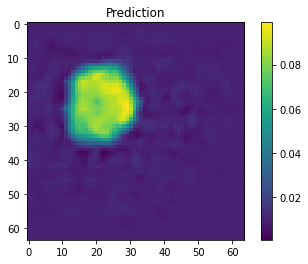

In [ ]:
mua_hat=model.predict(norm_data_test)
plt.imshow(mua_hat[105].reshape(64,64))
plt.title('Prediction')
#plt.colorbar()
plt.colorbar()

In [ ]:
img=mua_test[105]#.reshape(64,64)
#img=plt.imread(image)
#img=image.all()
all(i <0.08 for i in img)
#if img.all() < 0.08 and img.all() >0.08 :
img[i]=0.01
image=img.reshape(64,64)
plt.imshow(img)  
plt.colorbar()

NameError: ignored

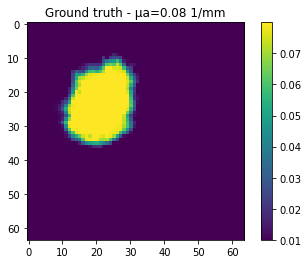

In [ ]:
plt.imshow(mua_test[105].reshape(64,64))
plt.title('Ground truth - \u03BCa=0.08 1/mm')
plt.colorbar()

#Evaluating metrics

In [ ]:
def MSE(y_test, y_pred):
    """ Mean Squared Error """
    mse = np.sum((y_test - y_pred) ** 2) / (y_test.shape[0] * y_test.shape[1])
    return mse

In [ ]:
def MAE(y_test, y_pred):
    """  Mean absolute error """
    abe = np.sum(np.abs(y_test - y_pred)) / (y_test.shape[0] * y_test.shape[1])
    return abe

In [ ]:
def PSNR(y_test, y_pred):
    """ Peak Signal to Noise Ratio """
    mse = MSE(y_test, y_pred)
    ps = np.max(y_pred)
    psnr = 10 * np.log10(ps ** 2 / mse)
    return psnr

In [ ]:
index=100
y_test=mua_test[index].reshape(64,64)
y_pred=mua_hat[index].reshape(64,64)
mae=MAE(y_test, y_pred)
mse=MSE(y_test, y_pred)
psnr=PSNR(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Peak Signal to Noise Ratio:', psnr)

Mean Absolute Error: 0.002584002446383238
Mean Squared Error: 3.227312845410779e-05
Peak Signal to Noise Ratio: 23.532332787426547


In [ ]:
from skimage.metrics import structural_similarity
def SSIM(y_test_i, y_pred_i):
    """ Structutal Similarity Index """
    s, m = structural_similarity(
        y_test_i, y_pred_i, data_range=(y_test_i.max() - y_test_i.min()), full=True
    )
    return s, m

In [ ]:
#y_test_i=plt.imread('/content/Y_test.png')
#y_pred_i=plt.imread('/content/Y_pred.png')

#y_test_i = Image.open('/content/Y_test.png').convert('L')
#y_pred_i = Image.open('/content/Y_pred.png').convert('L')
#y_test_i.save('gy_test_i.png')
#y_pred_i.save('gy_pred_i.png')
#imgA=plt.imread('/content/gy_test_i.png')
#imgB=plt.imread('/content/gy_pred_i.png')
#print(img.shape)
ssim, mssim=SSIM(imgA, imgB )
print('Mean Structural Similarity:', mssim)
print('Structural Similarity:', ssim)

Mean Structural Similarity: [[0.7605827  0.74126507 0.7370957  ... 0.71854555 0.71598554 0.71679113]
 [0.74578793 0.73043355 0.72693192 ... 0.7265604  0.72626041 0.72708965]
 [0.71656938 0.68270572 0.64933709 ... 0.73575784 0.7349305  0.73552123]
 ...
 [0.72285046 0.7170632  0.71332519 ... 0.69487311 0.67993218 0.6953462 ]
 [0.70551824 0.70338561 0.69965475 ... 0.68937897 0.6722929  0.68924369]
 [0.70582879 0.70672201 0.70151353 ... 0.68338574 0.66342618 0.68527056]]
Structural Similarity: 0.5575389699625377


In [ ]:
mua_hat_=mua_hat.reshape(64,64,1)
mua_test_=mua_test.reshape(64,64,1)
mse=MSE(mua_test, mua_hat)
mae=MAE(mua_test, mua_hat)
psnr=PSNR(mua_hat, mua_test)
#mssim, ssim=SSIM(mua_hat_, mua_test_)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Peak Signal to Noise Ratio:', psnr)
#print('Mean Structural Similarity:', mssim)
#print('Structural Similarity:', ssim)

Mean Absolute Error: 0.0034921626
Mean Squared Error: 6.470514e-05
Peak Signal to Noise Ratio: 20.189308568316704


#One layer

In [ ]:
def MLP_one_model():
  #define model
  #input=data_train.shape[1]
  model=Sequential()
  #model.add(Dense(256, activation='relu',input_shape=(625,)))#, kernel_initializer='he_uniform'))
  #model.add(GaussianNoise(0.1))
  model.add(Dense(1024, activation='relu',input_shape=(625,)))
  model.add(Dense(4096, activation='relu'))#,kernel_initializer='he_uniform' ))
  #opt=SGD(lr=0.01, momentum=0.99, decay=0.001)
  model.compile(loss='mean_squared_error', optimizer='adam',  metrics=['mean_absolute_error'])
  #round(model.optimizer.lr.numpy(), 5)
  model.summary()
  return  model


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 1024)              641024    
                                                                 
 dense_22 (Dense)            (None, 4096)              4198400   
                                                                 
Total params: 4,839,424
Trainable params: 4,839,424
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
96/96 [==============================] - 1s 9ms/step - loss: 5.8826e-04 - mean_absolute_error: 0.0113 - val_loss: 1.8874e-04 - val_mean_absolute_error: 0.0089
Epoch 2/1000
96/96 [==============================] - 1s 6ms/step - loss: 1.6168e-04 - mean_absolute_error: 0.0080 - val_loss: 1.3442e-04 - val_mean_absolute_error: 0.0073
Epoch 3/1000
96/96 [==============================] - 0s 5ms/step - loss: 1.1196e-04 - mean_abs

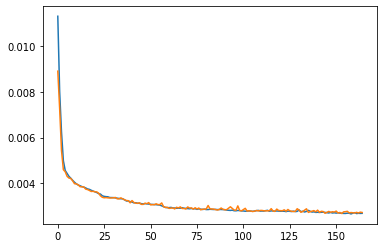

Text(0.5, 1.0, 'learning curve')

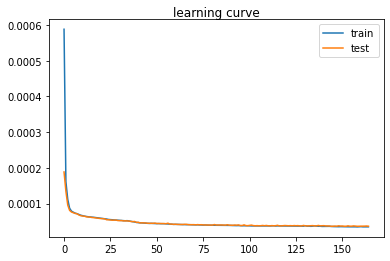

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 625,1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 625,1 )
norm_data_val=norm_data_val.reshape(len(norm_data_val), 625,1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096,1)
mua_val=mua_val.reshape(len(mua_val), 4096,1 )

model=MLP_one_model()

history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

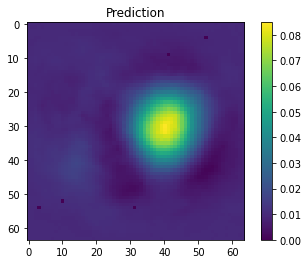

In [ ]:
mua_hat=model.predict(norm_data_test)
plt.imshow(mua_hat[0].reshape(64,64))
plt.title('Prediction')
#plt.colorbar()
plt.colorbar()

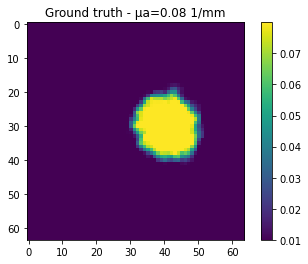

In [ ]:
plt.imshow(mua_test[0].reshape(64,64))
plt.title('Ground truth - \u03BCa=0.08 1/mm')
plt.colorbar()

#Conv2D Neural Network

In [ ]:
def conv_2d():
  model=Sequential()
  model.add(Conv2D(32,(2,2),activation='relu', padding='same', input_shape=(25,25,1)))
  model.add(Conv2D(32,(2,2),activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2))
  model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
  model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2))
  #model.add(Conv2D(64,(2,2),activation='relu'))
  #model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Conv2D(128,(5,5),activation='relu',padding='same'))
  #model.add(Conv2D(128,(5,5),activation='relu',padding='same'))
  #model.add(MaxPool2D(pool_size=(2,2), strides=2))
  model.add(Flatten())
  model.add(Dense(625, activation='relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(4096, activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
  model.summary()
  return model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 25, 25, 32)        160       
                                                                 
 conv2d_53 (Conv2D)          (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_55 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

Text(0.5, 1.0, 'learning curve')

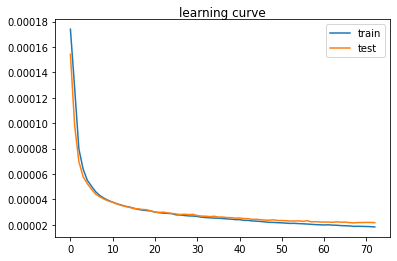

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 25, 25, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 25, 25, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)

model=conv_2d()
history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_test, mua_test), callbacks=[EL])
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/model_conv_final_5.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/model_conv_final_4.h5')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 25, 25, 32)        160       
                                                                 
 conv2d_49 (Conv2D)          (None, 25, 25, 32)        4128      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_51 (Conv2D)          (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                 

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 25, 25, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 25, 25, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)

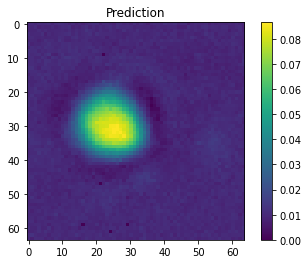

In [ ]:
mua_hat=model.predict(norm_data_test)
plt.imshow(mua_hat[16].reshape(64,64))
plt.title('Prediction')
plt.colorbar()

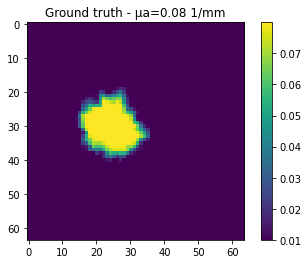

In [ ]:
plt.imshow(mua_test[16].reshape(64,64))
plt.title('Ground truth - \u03BCa=0.08 1/mm')
plt.colorbar()

In [ ]:
index=255
y_test=mua_test[index].reshape(64,64)
y_pred=mua_hat[index].reshape(64,64)
mae=MAE(y_test, y_pred)
mse=MSE(y_test, y_pred)
psnr=PSNR(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Peak Signal to Noise Ratio:', psnr)

Mean Absolute Error: 0.0022622481919825077
Mean Squared Error: 2.4839671823428944e-05
Peak Signal to Noise Ratio: 24.018318428373657


#MODEL3

In [ ]:
def dense_conv():
  model=Sequential()
  #model.add(Dense(256, activation='relu', input_shape=(625,)))
  #model.add(GaussianNoise(0.1))
  model.add(Dense(625,  activation='relu',input_shape=(625,)))
  model.add(GaussianNoise(0.1))
  #model.add(Dropout(0.2))
  model.add(Reshape((25,25,1)))

  #model.add(Conv1D(32,2, activation='relu', padding='same'))
  #model.add(Conv1D(32,2, activation='relu', padding='same'))
  #model.add(Reshape((25,25)))
  model.add(Conv2D(32,(3,3),activation='relu', padding='same'))
  model.add(Conv2D(32,(3,3),activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2))
  model.add(Conv2D(64,(5,5),activation='relu', padding='same'))
  model.add(Conv2D(64,(5,5),activation='relu', padding='same'))
  model.add(MaxPool2D(pool_size=(2,2), strides=2))
  #model.add(Conv2D(64,(7,7),activation='relu', padding='same'))
  #model.add(Conv2D(64,(7,7),activation='relu', padding='same'))
  model.add(Flatten())
  #model.add(Dense(625, activation='relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(4096, activation='relu'))
  model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
  model.summary()
  return model

In [ ]:
  #model.add(Dense(256, activation='relu', input_shape=(625,1)))
  #model.add(GaussianNoise(0.1))
  #model.add(Dense(625,  activation='relu'))
  #model.add(Dropout(0.2))
  #model.add(Reshape((25,25,1)))

  #model.add(Conv1D(32,3, activation='relu', padding='same'))
  #model.add(Conv1D(32,3, activation='relu', padding='same'))
  #model.add(Reshape((625,1)))
  model=dense_conv()
  model.output

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 625)               391250    
                                                                 
 gaussian_noise_2 (GaussianN  (None, 625)              0         
 oise)                                                           
                                                                 
 reshape_2 (Reshape)         (None, 25, 25, 1)         0         
                                                                 
 conv2d_12 (Conv2D)          (None, 25, 25, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_5')>

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 625)               391250    
                                                                 
 gaussian_noise_4 (GaussianN  (None, 625)              0         
 oise)                                                           
                                                                 
 reshape_4 (Reshape)         (None, 25, 25, 1)         0         
                                                                 
 conv2d_24 (Conv2D)          (None, 25, 25, 32)        320       
                                                                 
 conv2d_25 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                  

Text(0.5, 1.0, 'learning curve')

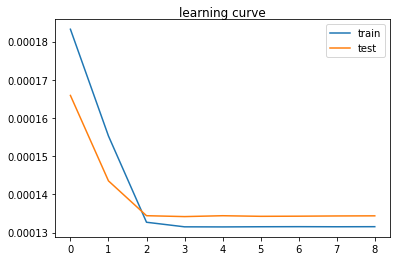

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 625, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 625, 1)
norm_data_val=norm_data_val.reshape(len(norm_data_val), 625, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)
mua_val=mua_val.reshape(len(mua_val), 4096, 1)

model=dense_conv()
history=model.fit(norm_data_train, mua_train, epochs=500, batch_size=128, validation_data=(norm_data_val, mua_val), callbacks=[EL])#,LS])
#round(model.optimizer.lr.numpy(), 5)
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
#plt.plot(history.history['mean_absolute_error'])
#plt.plot(history.history['val_mean_absolute_error'])
#plt.show()
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

In [ ]:
  model=Sequential()
  model.add(Dense(625, input_shape=(625,), activation='relu'))
  model.add(Reshape((625,1)))
  model.add(Conv1D(32,3, activation='relu', padding='same'))
  model.add(Conv1D(32,3,activation='relu', padding='same'))
  model.add(Reshape((25,25,32)))
  #model.add(AveragePooling2D(pool_size=(2,2), strides=2))
  model.add(Conv2D(32,(3,3),activation='relu', padding='same'))
  #model.add(Conv2D(64,(3,3),activation='relu', padding='same'))
  model.output

<KerasTensor: shape=(None, 25, 25, 32) dtype=float32 (created by layer 'conv2d_95')>

In [ ]:
norm_data_train=norm_data_train.reshape(len(norm_data_train), 625, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 625, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)

model=dense_1dconv()
history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=85, validation_data=(norm_data_test, mua_test),shuffle=True, callbacks=[EL])
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

NameError: ignored

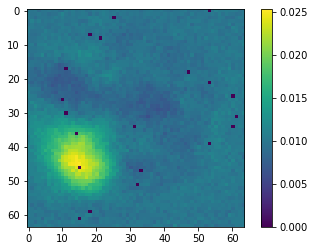

In [ ]:
mua_hat=model.predict(norm_data_test)
plt.imshow(mua_hat[9].reshape(64,64))
plt.colorbar()

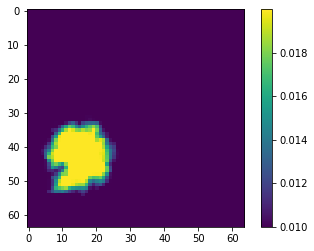

In [ ]:
#mua_hat=model.predict(norm_data_test)
plt.imshow(mua_test[9].reshape(64,64))
plt.colorbar()

In [ ]:
index=255
y_test=mua_test[index].reshape(64,64)
y_pred=mua_hat[index].reshape(64,64)
mae=MAE(y_test, y_pred)
mse=MSE(y_test, y_pred)
psnr=PSNR(y_test, y_pred)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Peak Signal to Noise Ratio:', psnr)

Mean Absolute Error: 0.0018556297291070223
Mean Squared Error: 1.7778245819499716e-05
Peak Signal to Noise Ratio: 24.095959561471826


In [ ]:
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        #x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,24,16]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    x= Dense(1024,activation='relu')(x) 
    x= Dropout(0.5)(x) 
    output = Dense(n_classes, activation = 'relu')(x)
    
    model = Model(input, output)
    return model
input_shape = 25, 25, 1
n_classes = 4096
model = densenet(input_shape,n_classes)
#model.summary()

Epoch 1/1000
108/108 [==============================] - 26s 151ms/step - loss: 1.2933e-04 - mae: 0.0056 - val_loss: 1.1411e-04 - val_mae: 0.0052
Epoch 2/1000
108/108 [==============================] - 15s 137ms/step - loss: 1.0475e-04 - mae: 0.0048 - val_loss: 1.3928e-04 - val_mae: 0.0073
Epoch 3/1000
108/108 [==============================] - 15s 137ms/step - loss: 9.0370e-05 - mae: 0.0047 - val_loss: 7.3834e-04 - val_mae: 0.0206
Epoch 4/1000
108/108 [==============================] - 15s 137ms/step - loss: 7.8298e-05 - mae: 0.0045 - val_loss: 0.0356 - val_mae: 0.1305
Epoch 5/1000
108/108 [==============================] - 15s 140ms/step - loss: 7.1876e-05 - mae: 0.0043 - val_loss: 0.5772 - val_mae: 0.5103
Epoch 6/1000
108/108 [==============================] - 15s 137ms/step - loss: 6.7690e-05 - mae: 0.0041 - val_loss: 2.0652 - val_mae: 0.9880
Epoch 7/1000
108/108 [==============================] - 15s 137ms/step - loss: 6.3017e-05 - mae: 0.0040 - val_loss: 2.9513 - val_mae: 1.0884
E

Text(0.5, 1.0, 'learning curve')

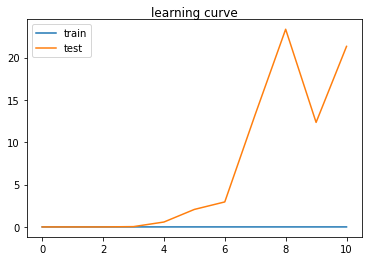

In [ ]:

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
norm_data_train=norm_data_train.reshape(len(norm_data_train), 25, 25, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 25, 25, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)
history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_test, mua_test), shuffle=True, callbacks=[EL])
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

#MODEL4

In [ ]:
def cnn_2():
  model=Sequential()
  model.add(Conv2D(32,(1,1),activation='relu',strides=1, padding='same',input_shape=(25,25,1)))
  model.add(MaxPool2D((2,2)))
  for i in range(6):
     model.add(Conv2D(128,(1,1),activation='relu',strides=1, padding='same'))
     model.add(Conv2D(64,(3,3),activation='relu',strides=1, padding='same'))

  model.add(Conv2D(32,(1,1),activation='relu'))
  model.add(AvgPool2D((2,2),(2,2),padding='same'))
  for i in range(12):
     model.add(Conv2D(128,(1,1),activation='relu',strides=1, padding='same'))
     model.add(Conv2D(64,(3,3),activation='relu',strides=1, padding='same'))

  model.add(Conv2D(32,(1,1), activation='relu'))
  model.add(AvgPool2D((2,2),(2,2),padding='same'))  
  for i in range(24):
     model.add(Conv2D(128,(1,1),activation='relu',strides=1, padding='same'))
     model.add(Conv2D(64,(3,3),activation='relu',strides=1, padding='same'))

  model.add(Conv2D(32,(1,1), activation='relu'))
  model.add(AvgPool2D((2,2),(2,2),padding='same'))

  #for i in range(16):
     #model.add(Conv2D(128,(1,1),activation='relu',strides=1, padding='same'))
     #model.add(Conv2D(64,(3,3),activation='relu',strides=1, padding='same'))

  model.add(Conv2D(32,(1,1),activation='relu'))
  model.add(AvgPool2D((2,2),(2,2),padding='same')) 
  model.add(Dense(625, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(4096, activation='relu'))

  return model

In [ ]:
model=cnn_2()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_315 (Conv2D)         (None, 25, 25, 32)        64        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_316 (Conv2D)         (None, 12, 12, 128)       4224      
                                                                 
 conv2d_317 (Conv2D)         (None, 12, 12, 64)        73792     
                                                                 
 conv2d_318 (Conv2D)         (None, 12, 12, 128)       8320      
                                                                 
 conv2d_319 (Conv2D)         (None, 12, 12, 64)        73792     
                                                     

In [ ]:
model=cnn_2()
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
norm_data_train=norm_data_train.reshape(len(norm_data_train), 25, 25, 1)
norm_data_test=norm_data_test.reshape(len(norm_data_test), 25, 25, 1)
mua_train=mua_train.reshape(len(mua_train), 4096,1)
mua_test=mua_test.reshape(len(mua_test), 4096, 1)
history=model.fit(norm_data_train, mua_train, epochs=1000, batch_size=128, validation_data=(norm_data_test, mua_test),shuffle=True, callbacks=[EL])
test_loss=model.evaluate(norm_data_test, mua_test, steps=10)
#plot learning curves
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title('learning curve', pad=-50)

Epoch 1/1000


ResourceExhaustedError: ignored